**Code for scraping Images.**

The scraping of different broughts is done below.

There are 3 main products : *tractors, electronics, and bicycles.*

The Product Images are fetched from [iStockphoto LP](https://www.istockphoto.com/) and are freely available.



In [1]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.request import urlretrieve

def scrape_and_download_images(urls, num_pages=1):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
    }

    all_image_urls = []

    for url in urls:
        image_urls = []

        for page in range(1, num_pages + 1):
            page_url = f"{url}&page={page}"
            response = requests.get(page_url, headers=headers)

            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')

                # Selecting images based on the class or image tag
                image_tags = soup.select('.Up7tj_EQVFh6e6sV17Ud img.yGh0CfFS4AMLWjEE9W7v')

                for image_tag in image_tags:
                    image_url = image_tag.get('src')
                    if image_url:
                        image_urls.append(image_url)

        all_image_urls.extend(image_urls)

    folder_path = '/content/drive/MyDrive/Data Mining/Downloaded_images'
    os.makedirs(folder_path, exist_ok=True)

    # Download images
    for idx, image_url in enumerate(all_image_urls, start=1):
        image_name = f'image_{idx}.jpg'
        image_path = os.path.join(folder_path, image_name)

        # Check if the image already exists, if yes, skip
        if not os.path.exists(image_path):
            # Download the image
            urlretrieve(image_url, image_path)
        else:
            print(f"Skipped image {idx}/{len(all_image_urls)} (already exists)")

# Image urls for Tractors, Electronics, bicycles
urls = [
    "https://www.istockphoto.com/search/2/image-film?istockcollection=&phrase=bicycles",
    "https://www.istockphoto.com/search/2/image-film?istockcollection=&phrase=electronics",
    "https://www.istockphoto.com/search/2/image-film?istockcollection=&phrase=tractors"
]

scrape_and_download_images(urls, num_pages=1)


**Preprocessing**

In [2]:
import cv2
import os

# Params
data_dir = '/content/drive/MyDrive/Data Mining/Downloaded_images'
output_dir = '/content/drive/MyDrive/Data Mining/Downloaded_images'
image_exts = ['.jpg']
target_size = (224, 224)


def resize_images(input_dir, output_dir, image_exts, target_size):
    for image in os.listdir(input_dir):
        image_path = os.path.join(input_dir, image)
        _, extension = os.path.splitext(image_path)


        if extension.lower() not in image_exts:
            print('Image not in ext  {}'.format(image_path))
            os.remove(image_path)
            continue

        try:
            img = cv2.imread(image_path)

            # Resize the image to 224 by 224
            img_resized = cv2.resize(img, target_size)

            output_path = os.path.join(output_dir, image)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, img_resized)

        except Exception as e:
            print('Issue with image {}'.format(image_path))

resize_images(data_dir, output_dir, image_exts, target_size)


**Feature Extraction**

To extract the distinct features from the images , I used a pretrained VGG16 model as it is robust, enabling efficient Image Extraction.

In [3]:
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input

# Pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in model.layers:
    layer.trainable = False

def extract_vgg16_features(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    features = features.flatten()
    features = features / np.linalg.norm(features)  # Normalized features
    return features

def load_and_extract_features(input_dir):
    vgg16_features = []
    file_info = []

    for image_name in os.listdir(input_dir):
        if image_name.lower().endswith(('.jpg')):
            image_path = os.path.join(input_dir, image_name)
            try:
                img = image.load_img(image_path, target_size=(224, 224))

                # Convert the image to numpy array and extract VGG16 features
                features = extract_vgg16_features(img)

                # Store VGG16 features in one list
                vgg16_features.append(features)

                # Store file information in another list
                file_info.append({
                    'file_path': image_path,
                    'file_name': image_name
                })
            except Exception as e:
                print(f'Issue with image {image_path}: {str(e)}')

    return vgg16_features, file_info

input_dir = '/content/drive/MyDrive/Data Mining/Downloaded_images'
vgg16_features, file_info = load_and_extract_features(input_dir)

# vgg16_features is a list of VGG16 features
# file_info is a list of dictionaries, each containing file_path and file_name


1/1 [==============================] - 1s 528ms/step


In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix_pca = pca.fit_transform(vgg16_features)

**Optimum clusters, k**

Used Elbow method to determine this. I explained it in the News Notebook.
Based on the results , the Optimum clusters should be 3.

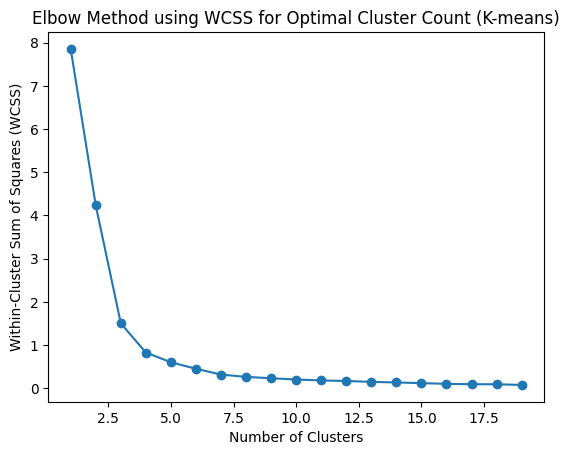

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculates WCSS for various clusters
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(matrix_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss, marker='o')
plt.title('Elbow Method using WCSS for Optimal Cluster Count (K-means)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()



In [6]:
optimal_clusters = 3

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)


In [7]:
!pip install plotly

In [8]:
import plotly.graph_objs as go
import numpy as np

cluster_labels = kmeans.fit_predict(matrix_pca)
centroids = kmeans.cluster_centers_

cluster_colors = ['yellow', 'green', 'purple']

# Scatter plot for clustered data
scatter_traces = []
unique_clusters = np.unique(cluster_labels)

for i, cluster in enumerate(unique_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_trace = go.Scatter(
        x=matrix_pca[cluster_indices, 0],
        y=matrix_pca[cluster_indices, 1],
        mode='markers',
        marker=dict(
            color=cluster_colors[i],
            size=8,
            line=dict(color='black', width=1)
        ),
        name=f'Cluster {cluster}'
    )
    scatter_traces.append(cluster_trace)

# Scatter plot for centroids
centroid_trace = go.Scatter(
    x=centroids[:, 0],
    y=centroids[:, 1],
    mode='markers',
    marker=dict(
        color='red',
        size=14,
        symbol='x'
    ),
    name='Centroids'
)

# Layout settings
layout = go.Layout(
    title='Scatter Plot with Clustered Data and Centroids',
    xaxis=dict(title='Principal Component 1'),
    yaxis=dict(title='Principal Component 2'),
)

# Create the figure
fig = go.Figure(data=scatter_traces + [centroid_trace], layout=layout)

fig.show()


In [9]:
unique_clusters

array([0, 1, 2], dtype=int32)

Each label in the **cluster_labels** is a cluster identifier for each image in our dataset. The order of the labels is parallel to the list of filenames for each image. This way we can group the images into their clusters.

Ref : https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [10]:
cluster_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

**Images Clusters**

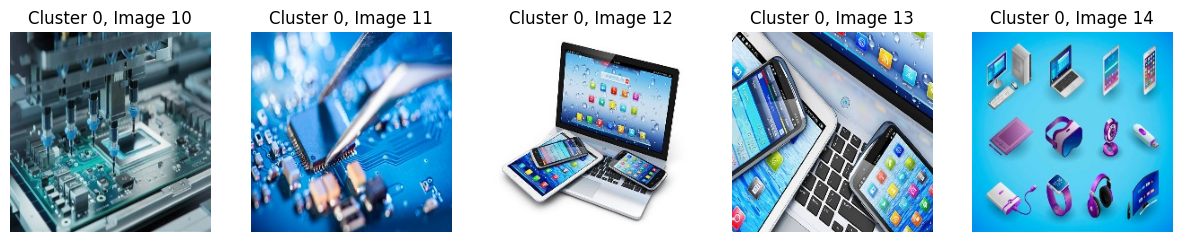

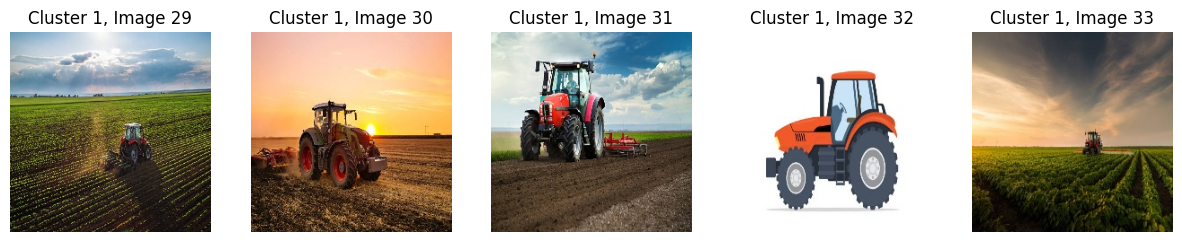

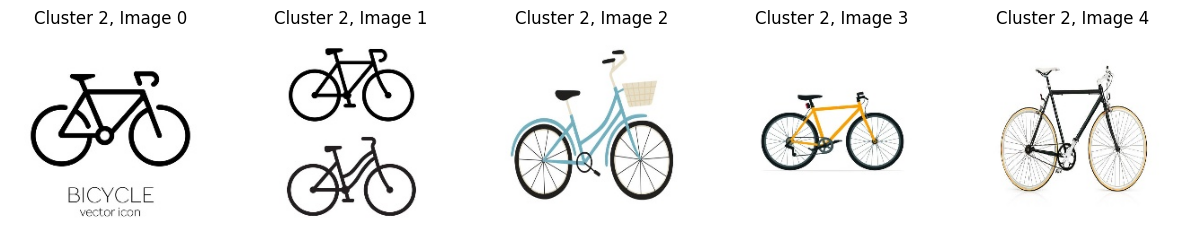

In [11]:
n_clusters = 3


# Visualize 5 images for each cluster
for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    sample_indices = cluster_indices[:5]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, 5, i + 1)

        # Retrieve file information based on the index
        file_data = file_info[idx]
        image_path = file_data['file_path']
        img = image.load_img(image_path, target_size=(224, 224))
        plt.imshow(img)

        plt.title(f'Cluster {cluster}, Image {idx}')
        plt.axis('off')
    plt.show()

In [12]:
cluster_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

**Model Evaluation**

In [13]:
from sklearn.metrics import silhouette_score
